In [2]:
from networkx.generators.random_graphs import connected_watts_strogatz_graph
import networkx as nx
from random import random, sample
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import cycle
import numpy as np
import time

In [3]:
def step_posts(g, yesterday_posts, population_A=set(), intrinsic=1/4, network_effect=3/200, effect_size = 0.00):
    today_posts = defaultdict(int)
    # baseline
    for v in g.nodes:
        if v in population_A:
            # experiment
            today_posts[v] = intrinsic * (1 + effect_size)
        else:
            today_posts[v] = intrinsic
    # network effect
    if yesterday_posts is not None:
        for (v1, v2) in g.edges:
            today_posts[v2] += yesterday_posts[v1] * network_effect
    return today_posts

def compute_stats(g, population_A, T=30):
    friends_of_A = set([])
    for (v1, v2) in g.edges:
        if v1 in population_A and v2 not in population_A:
            friends_of_A.add(v2)
    rest = set(g.nodes) - population_A
    rest = rest - friends_of_A
    posts = prev_posts = None
    for t in range(T):
        posts = step_posts(g, prev_posts, population_A=population_A, effect_size=0.05)
        prev_posts = posts
    avg_posts_all = np.mean(list(posts.values()))
    avg_posts_A = np.mean([v for (k, v) in posts.items() if k in population_A])
    avg_posts_A_friends = np.mean([v for (k, v) in posts.items() if k in friends_of_A])
    avg_posts_rest = np.mean([v for (k, v) in posts.items() if k in rest])
    return (avg_posts_A, avg_posts_A_friends, avg_posts_rest, avg_posts_all)

def monte_carlo_stats(n, num_simulations=50, N=100):
    stats_list = []
    for i in range(num_simulations):
        start_time = time.time()
        g = connected_watts_strogatz_graph(n, k=50, p=0.1).to_directed()
        population_A = set(sample(g.nodes, N))
        stats = compute_stats(g, population_A)
        stats_list.append(stats)
        elapsed_time = time.time() - start_time
        print(n, i, time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
    avg_stats = [np.mean([x[i] for x in stats_list]) for i in range(len(stats_list[0]))]
    return avg_stats

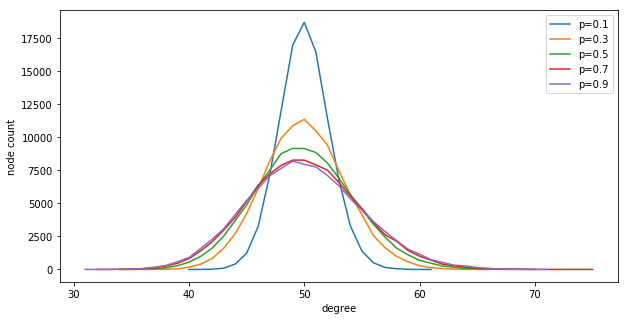

In [3]:
degrees = {}
for p in range(10, 110, 20):
    p /= 100.0
    g = connected_watts_strogatz_graph(n=100*1000, k=50, p=p)
    ds = Counter(sorted([d for n, d in g.degree()], reverse=True))
    d, c = zip(*ds.items())
    degrees[p] = (d, c)

plt.figure(figsize=(10,5))
plt.xlabel('degree')
plt.ylabel('node count')
for _, v in degrees.items():
    plt.plot(v[0], v[1])
plt.legend(['p=%s' % p for p in degrees])
plt.show()

In [ ]:
T = 30
ns = [10*1000, 50*1000, 100*1000, 200*1000]
post_lifts = defaultdict(list)

for n in ns:
    for p in range(0, 110, 20):
        p /= 100.0
        g = connected_watts_strogatz_graph(n=n, k=50, p=p).to_directed()
        posts = prev_posts = None
        for t in range(T):
            posts = step_posts(g, prev_posts)
            prev_posts = posts
        avg_posts_all = np.mean(list(posts.values()))
        post_lifts[n].append((p, avg_posts_all))

plt.figure(figsize=(10,5))
plt.xlabel('watts-strogatz p')
plt.ylabel('avg posts lift %')
for _, v in post_lifts.items():
    plt.plot([x[0] for x in v], [x[1] for x in v], marker='o', linestyle='--')
plt.legend(['n=%dk' % (n/1000) for n in post_lifts])
plt.show()

In [7]:
n=100*1000
k=50
p=0.1
g = connected_watts_strogatz_graph(n=n, k=k, p=p).to_directed()
posts = prev_posts = None
T=30
for t in range(T):
    posts = step_posts(g, prev_posts)
    prev_posts = posts
baseline_avg_posts = np.mean(list(posts.values()))
print("Correct baseline for a (%s, %s, %s) Watts-Strogatz graph = %.4f" % (n, k, p, baseline_avg_posts))

Correct baseline for a (100000, 50, 0.1) Watts-Strogatz graph = 1.0042


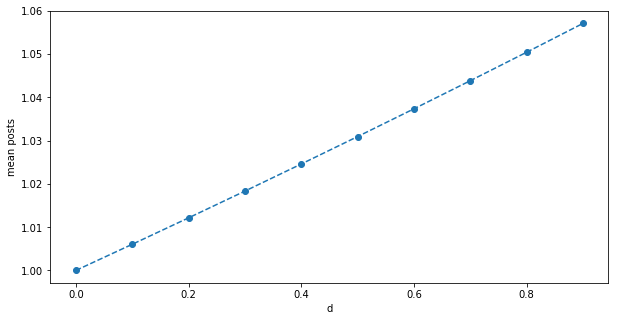

In [15]:
def c(d): return (1/4) / (1-(50+d)*(3/200))
plt.figure(figsize=(10,5))
plt.xlabel('d')
plt.ylabel('mean posts')
fd = [(d/10.0, c(d/10.0)) for d in range(0, 10)]
plt.plot([x[0] for x in fd], [x[1] for x in fd], marker='o', linestyle='--')
plt.show()

In [5]:
ns = list(range(10*1000, 100*1000, 20*1000)) + list(range(100*1000, 300*1000, 100*1000))
stats_list = [(n, monte_carlo_stats(n)) for n in ns]

10000 0 00:00:03
10000 1 00:00:06
10000 2 00:00:03
10000 3 00:00:04
10000 4 00:00:04
10000 5 00:00:03
10000 6 00:00:04
10000 7 00:00:04
10000 8 00:00:03
10000 9 00:00:04
10000 10 00:00:03
10000 11 00:00:03
10000 12 00:00:03
10000 13 00:00:03
10000 14 00:00:03
10000 15 00:00:03
10000 16 00:00:04
10000 17 00:00:03
10000 18 00:00:04
10000 19 00:00:03
10000 20 00:00:03
10000 21 00:00:03
10000 22 00:00:04
10000 23 00:00:04
10000 24 00:00:03
10000 25 00:00:04
10000 26 00:00:04
10000 27 00:00:04
10000 28 00:00:04
10000 29 00:00:03
10000 30 00:00:03
10000 31 00:00:03
10000 32 00:00:03
10000 33 00:00:04
10000 34 00:00:03
10000 35 00:00:04
10000 36 00:00:03
10000 37 00:00:04
10000 38 00:00:03
10000 39 00:00:03
10000 40 00:00:03
10000 41 00:00:03
10000 42 00:00:03
10000 43 00:00:03
10000 44 00:00:03
10000 45 00:00:04
10000 46 00:00:03
10000 47 00:00:04
10000 48 00:00:03
10000 49 00:00:03
30000 0 00:00:12
30000 1 00:00:12
30000 2 00:00:12
30000 3 00:00:12
30000 4 00:00:12
30000 5 00:00:12
30000 6 

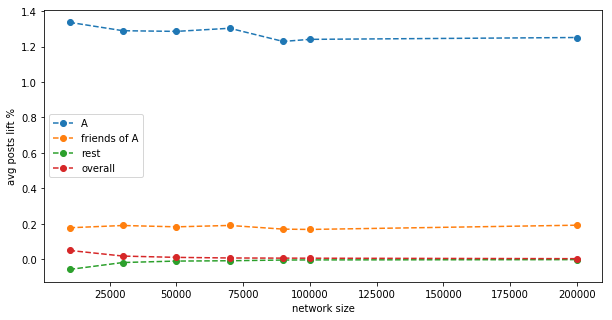

In [8]:
ns = [stats[0] for stats in stats_list]
def lift(x): return (x/baseline_avg_posts - 1)*100
plt.figure(figsize=(10,5))
plt.xlabel('network size')
plt.ylabel('avg posts lift %')
plt.plot(ns, [lift(stats[1][0]) for stats in stats_list], marker='o', linestyle='--', color='#1f77b4')
plt.plot(ns, [lift(stats[1][1]) for stats in stats_list], marker='o', linestyle='--', color='#ff7f0e')
plt.plot(ns, [lift(stats[1][2]) for stats in stats_list], marker='o', linestyle='--', color='#2ca02c')
plt.plot(ns, [lift(stats[1][3]) for stats in stats_list], marker='o', linestyle='--', color='#d62728')
plt.legend([
    'A',
    'friends of A',
    'rest',
    'overall',
], loc='center left')
plt.show()

In [4]:
ns2 = [200*1000, 100*1000] #list(range(100*1000, 300*1000, 100*1000))
stats_list2 = [(n, monte_carlo_stats(n, N=1000)) for n in ns2]

200000 0 00:01:35
200000 1 00:01:35
200000 2 00:01:32
200000 3 00:01:32
200000 4 00:01:32
200000 5 00:01:32
200000 6 00:01:31
200000 7 00:01:33
200000 8 00:01:31
200000 9 00:01:33
200000 10 00:01:31
200000 11 00:01:32
200000 12 00:01:30
200000 13 00:01:32
200000 14 00:01:30
200000 15 00:01:32
200000 16 00:01:30
200000 17 00:01:32
200000 18 00:01:30
200000 19 00:01:32
200000 20 00:01:30
200000 21 00:01:32
200000 22 00:01:30
200000 23 00:01:33
200000 24 00:01:30
200000 25 00:01:33
200000 26 00:01:31
200000 27 00:01:33
200000 28 00:01:30
200000 29 00:01:34
200000 30 00:01:31
200000 31 00:01:31
200000 32 00:01:33
200000 33 00:01:32
200000 34 00:01:32
200000 35 00:01:31
200000 36 00:01:33
200000 37 00:01:32
200000 38 00:01:31
200000 39 00:01:37
200000 40 00:01:31
200000 41 00:01:32
200000 42 00:01:32
200000 43 00:01:32
200000 44 00:01:32
200000 45 00:01:32
200000 46 00:01:31
200000 47 00:01:33
200000 48 00:01:31
200000 49 00:01:32
100000 0 00:00:47
100000 1 00:00:44
100000 2 00:00:44
100000

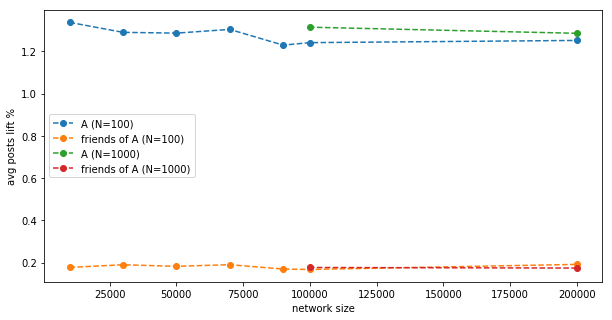

In [14]:
ns = [stats[0] for stats in stats_list2]
def lift(x): return (x/baseline_avg_posts - 1)*100
plt.figure(figsize=(10,5))
plt.xlabel('network size')
plt.ylabel('avg posts lift %')
plt.plot([stats[0] for stats in stats_list], [lift(stats[1][0]) for stats in stats_list], marker='o', linestyle='--')
plt.plot([stats[0] for stats in stats_list], [lift(stats[1][1]) for stats in stats_list], marker='o', linestyle='--')
plt.plot([stats[0] for stats in stats_list2], [lift(stats[1][0]) for stats in stats_list2], marker='o', linestyle='--')
plt.plot([stats[0] for stats in stats_list2], [lift(stats[1][1]) for stats in stats_list2], marker='o', linestyle='--')
plt.legend([
    'A (N=100)',
    'friends of A (N=100)',
    'A (N=1000)',
    'friends of A (N=1000)',
], loc='center left')
plt.show()